## **Identifying Key Contributors to Road Traffic Accidents Using XGBoost and Exploratory Data Analysis**
### Objectives
* To explore and analyze road traffic crash data to understand patterns and trends in accidents.
* To develop a predictive machine learning model to classify accident severity.
* To evaluate the performance of the predictive model using appropriate metrics such as accuracy, precision, recall and F1-score.
* To provide data-driven recommendations for improving road safety and reducing accident severity.

In [371]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
sns.set_style('darkgrid', {'axes.facecolor':'0.9'})
from scipy.stats import f_oneway
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score

Loading the datasets

In [309]:
crashes=pd.read_csv('./data/Traffic_Crashes_-_Crashes.csv.gz', low_memory=False)
people=pd.read_csv('./data/Traffic_Crashes_-_People.csv.gz', low_memory=False)
vehicles=pd.read_csv('./data/Traffic_Crashes_-_Vehicles.csv.gz', low_memory=False)

### Exploring the crashes dataset

In [310]:
# checking the info of the crashes dataset
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH_RECORD_ID                54959 non-null  object 
 1   CRASH_DATE_EST_I               3503 non-null   object 
 2   CRASH_DATE                     54959 non-null  object 
 3   POSTED_SPEED_LIMIT             54959 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         54959 non-null  object 
 5   DEVICE_CONDITION               54959 non-null  object 
 6   WEATHER_CONDITION              54959 non-null  object 
 7   LIGHTING_CONDITION             54959 non-null  object 
 8   FIRST_CRASH_TYPE               54959 non-null  object 
 9   TRAFFICWAY_TYPE                54959 non-null  object 
 10  LANE_CNT                       6 non-null      float64
 11  ALIGNMENT                      54959 non-null  object 
 12  ROADWAY_SURFACE_COND           54959 non-null 

In [311]:
# Checking the column names of the crashes dataset
crashes.columns

Index(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 

In [312]:
# Checking for duplicate records in the crashes dataset
crashes.CRASH_RECORD_ID.duplicated().sum()

0

In [313]:
# Checking the values	counts of the MOST_SEVERE_INJURY column
crashes.MOST_SEVERE_INJURY.value_counts()

NO INDICATION OF INJURY     45514
NONINCAPACITATING INJURY     4982
REPORTED, NOT EVIDENT        3502
INCAPACITATING INJURY         809
FATAL                          47
Name: MOST_SEVERE_INJURY, dtype: int64

#### Creating a binary target variable using the IS_SEVERE column.

In [314]:
# Defining the severity of the accidents based on injury levels
crashes['IS_SEVERE'] = (
    (crashes['INJURIES_INCAPACITATING'] > 0) |
    (crashes['INJURIES_FATAL'] > 0)
)

In [315]:
# Checking the values counts of the ROADWAY_SURFACE_COND column
crashes.ROADWAY_SURFACE_COND.value_counts()

DRY                40314
UNKNOWN             7662
WET                 4588
SNOW OR SLUSH       1937
ICE                  271
OTHER                175
SAND, MUD, DIRT       12
Name: ROADWAY_SURFACE_COND, dtype: int64

###	Combining rare categories in the ROADWAY_SURFACE_COND column

In [316]:
crashes['ROADWAY_SURFACE_COND'].replace(['SAND, MUD, DIRT', 'OTHER'], 'OTHER_RARE', inplace=True)

In [317]:
# Checking the values counts of the WEATHER_CONDITION column
crashes.WEATHER_CONDITION.value_counts()

CLEAR                       44097
UNKNOWN                      4525
RAIN                         2825
SNOW                         1751
CLOUDY/OVERCAST              1379
OTHER                         200
FREEZING RAIN/DRIZZLE          74
BLOWING SNOW                   42
SLEET/HAIL                     40
FOG/SMOKE/HAZE                 22
SEVERE CROSS WIND GATE          3
BLOWING SAND, SOIL, DIRT        1
Name: WEATHER_CONDITION, dtype: int64

### Combining rare categories in the WEATHER_CONDITION column

In [318]:
crashes['WEATHER_CONDITION'].replace(['BLOWING SAND, SOIL, DIRT', 'OTHER'], 'OTHER_RARE', inplace=True)

### Analyzing the relationship between ROADWAY_SURFACE_COND and accident severity

In [319]:
crashes.groupby('ROADWAY_SURFACE_COND')['IS_SEVERE'].mean().sort_values(ascending=False)

ROADWAY_SURFACE_COND
WET              0.022886
DRY              0.016892
SNOW OR SLUSH    0.011874
OTHER_RARE       0.010695
ICE              0.007380
UNKNOWN          0.005612
Name: IS_SEVERE, dtype: float64

#### **In wet roadway surface the rate of injury severity is highest.**

### **Data Transformation: Discretization of Speed Limits.**
### Categorizing speed limits into ranges for comparative analysis.

In [320]:
#Converting the continuous POSTED_SPEED_LIMIT column into a discrete categorical feature named `SPEED_BIN`.
crashes['SPEED_BIN'] = pd.cut(
	crashes['POSTED_SPEED_LIMIT'],
	bins=[0, 25, 35, 45, 55, 65, 100],
	labels=['≤25', '30-35', '40-45', '50-55', '60-65', '65+'],
	include_lowest=True)

### **Distribution of Severe Injury Rates by Speed Limit**

#### The likelihood of a severe injury occurring in different speed limit zones

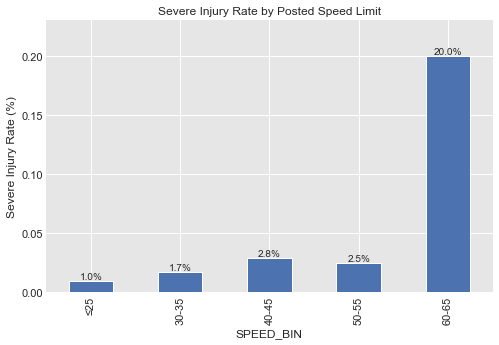

In [321]:
rates = crashes.groupby('SPEED_BIN')['IS_SEVERE'].mean()
rates = rates.dropna()
ax = rates.plot(kind='bar', figsize=(8,5))
plt.ylabel('Severe Injury Rate (%)')
plt.title('Severe Injury Rate by Posted Speed Limit')
plt.ylim(0, rates.max() * 1.15)
for i, rate in enumerate(rates):
    ax.text(
        i,
        rate,
        f"{rate:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

#### **The percentages represent the probability of a severe injury given a specific posted speed limit category. The likelihood of severe injuries in speed limits ranging from 60-65km/h is 20%.**

### **What are the Top 10 Streets with the highest number of crashes?**


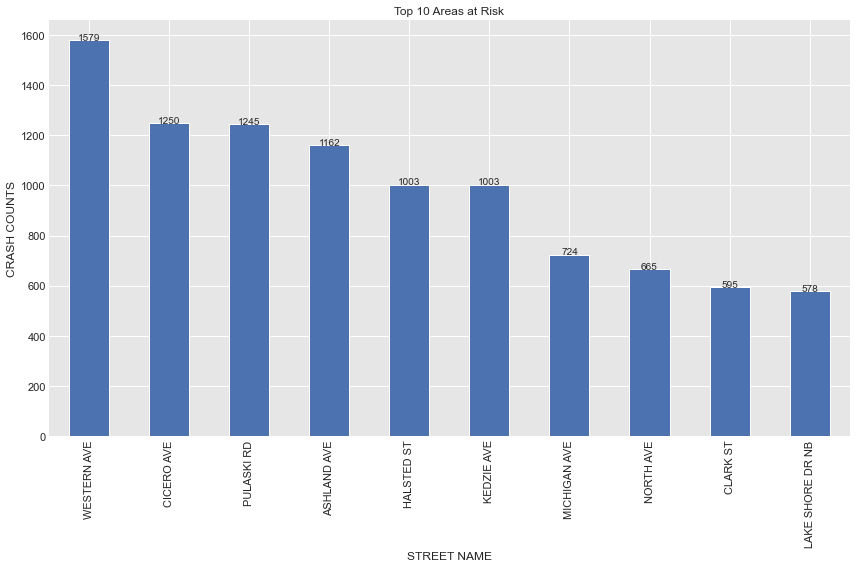

In [322]:
# top 10 areas at risk
top_10_risk_areas = crashes.STREET_NAME.value_counts().head(10)
top_10_risk_areas.plot(kind='bar', figsize=(12,8))
plt.title('Top 10 Areas at Risk')
plt.ylabel('CRASH COUNTS')
plt.xlabel('STREET NAME')
for i, rate in enumerate(top_10_risk_areas):
    plt.text(i, rate, s=f'{rate}', ha='center', fontsize=10)
plt.tight_layout();

#### **Western Avenue has the highest number of crashes with 1579 incidents followed by Cicero Avenue and Pulaski Road with more that 1200 crashes each.**

### **What is Crash Type Distribution?**

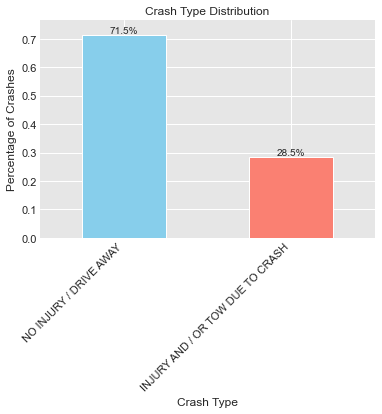

In [323]:
crash_type = crashes['CRASH_TYPE'].value_counts(normalize=True)
# Bar plot
crash_type.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Crash Type Distribution')
plt.xlabel('Crash Type')
plt.ylabel('Percentage of Crashes')
plt.ylim(0, crash_type.max() + 0.05)
plt.xticks(rotation=45, ha='right')
for i, rate in enumerate(crash_type):
    plt.text(
        i,
        rate + 0.005,
        f"{rate:.1%}",
        ha='center',
        fontsize=10
    );

#### **71.5%	of crashes result in No Injury / Property Damage Only, while 28.5% involve Injury and/or Fatal outcomes.**

## Analyzing primary contributing causes

In [324]:
# Checking the top 10 primary contributory causes of crashes
crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().head(10)

UNABLE TO DETERMINE                       22702
FAILING TO YIELD RIGHT-OF-WAY              6533
FOLLOWING TOO CLOSELY                      4989
IMPROPER OVERTAKING/PASSING                3034
NOT APPLICABLE                             2457
FAILING TO REDUCE SPEED TO AVOID CRASH     2269
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE        2189
IMPROPER TURNING/NO SIGNAL                 1899
IMPROPER LANE USAGE                        1833
IMPROPER BACKING                           1703
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64

### **What are the top 10 primary contributory causes of crashes?**

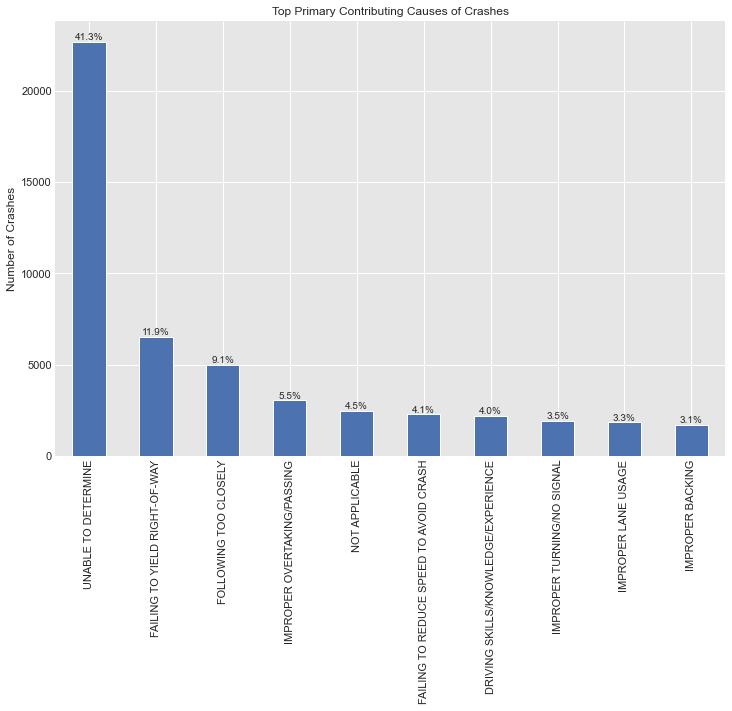

In [325]:
# Plot of top primary contributing causes of crashes
crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().head(10).plot(kind='bar', figsize=(12,8))
plt.title("Top Primary Contributing Causes of Crashes")
plt.ylabel("Number of Crashes")
plt.xticks(rotation=90)
total = crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().sum()
for i, rate in enumerate(crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().head(10)):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

#### **The leading	primary contributory cause of crashes is 'Unable to determine' but 'Failure to Yield Right-of-Way', 'Following Too Closely' and 'Improper Lane Usage' were among the top causes of the crashes that were determined.**

## Time-Based Analysis

### **What time of day do most crashes occur?**

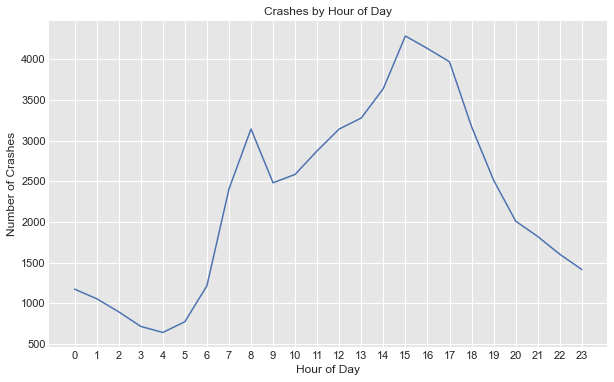

In [326]:
# Crash By Hour Plot
plt.figure(figsize=(10,6))
crashes['CRASH_HOUR'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Hour of Day')
plt.xticks(range(0,24))
plt.ylabel('Number of Crashes')
plt.title("Crashes by Hour of Day");

#### **Most crashes	occur during the afternoon hours, peaking around 3 PM to 6 PM, likely due to increased traffic during rush hour.**

### **What was the cause of crashes at 3 PM?**

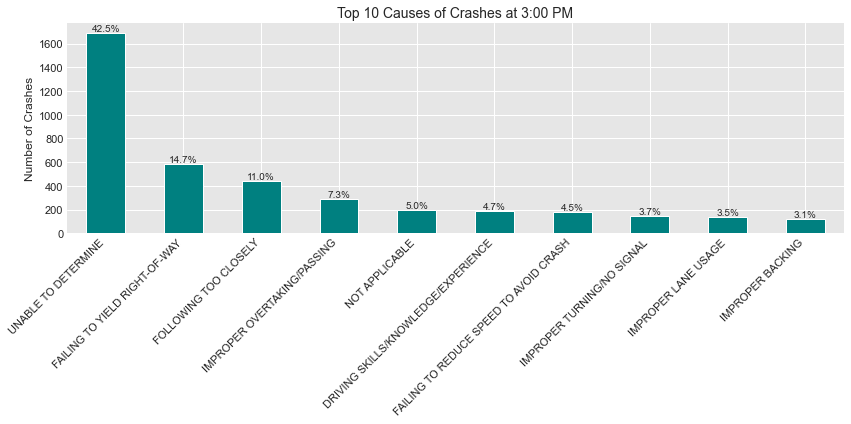

In [327]:
accidents_at_3pm = crashes[crashes["CRASH_HOUR"] == 15]
cause_col = [c for c in crashes.columns if 'CONTRIBUTORY_CAUSE' in c][0]
cause_counts = accidents_at_3pm[cause_col].value_counts().head(10)
plt.figure(figsize=(12, 6))
cause_counts.plot(kind='bar', color='teal')
plt.title(f'Top 10 Causes of Crashes at 3:00 PM', fontsize=14)
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45, ha='right')
total_at_hour = cause_counts.sum()
for i, count in enumerate(cause_counts):
    plt.text(i, count + 0.1, f'{(count/total_at_hour):.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### **The top causes	of crashes at 3 PM include 'Failure to Yield Right-of-Way', 'Following Too Closely', and 'Disregard Traffic Control Device'. These causes highlight common driver errors during peak traffic hours.**

### **What day of the week do most crashes occur?**

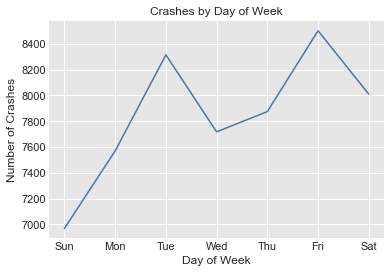

In [328]:
# Crashes By Day of Week Plot
crashes['CRASH_DAY_OF_WEEK'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Day of Week')
plt.xticks(range(1,8), ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.ylabel('Number of Crashes')
plt.title("Crashes by Day of Week");

#### **Friday and Tuesday have highest number of crashes with more than 8200 crashes while Sunday record the least number of crashes.**

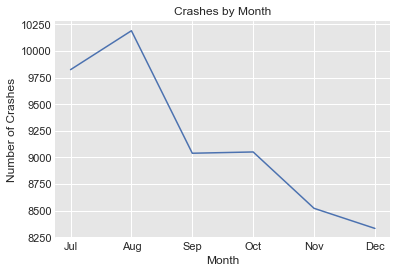

In [329]:
# Crash distribution monthly
crashes['CRASH_MONTH'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Month')
plt.xticks(range(7,13), ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Number of Crashes')
plt.title("Crashes by Month");

#### **August and July (Summer) have	the highest number of crashes while December(Winter) has the least number of crashes.**

## Statistical Tests

H<sub>0</sub>: Weather condition does not affect injuries VS
H<sub>1</sub>: Weather affects injuries at 1% level of significance

In [330]:
groups = [
    crashes[crashes['WEATHER_CONDITION'] == w]['INJURIES_TOTAL'].dropna()
    for w in crashes['WEATHER_CONDITION'].unique()
]
f_oneway(*groups)

F_onewayResult(statistic=36.390952708299125, pvalue=7.888266197739882e-72)

## Weather significantly affects the number of injuries.

H<sub>0</sub>: Lighting condition does not affect injuries VS
H<sub>1</sub>: Lighting affects injuries at 1% level of significance

In [331]:
groups = [
    crashes[crashes['LIGHTING_CONDITION'] == w]['INJURIES_TOTAL'].dropna()
    for w in crashes['LIGHTING_CONDITION'].unique()
]
f_oneway(*groups)

F_onewayResult(statistic=88.11142785500279, pvalue=1.2734770215895415e-92)

## Lighting condition affects the number of injuries at 1% level of significance.

In [332]:
crashes=crashes[['CRASH_RECORD_ID','WEATHER_CONDITION','LIGHTING_CONDITION','CRASH_TYPE','CRASH_HOUR','CRASH_MONTH','NUM_UNITS', 'ROADWAY_SURFACE_COND', 'POSTED_SPEED_LIMIT', 'IS_SEVERE', 'PRIM_CONTRIBUTORY_CAUSE', 'SPEED_BIN', 'CRASH_DAY_OF_WEEK', 'TRAFFIC_CONTROL_DEVICE', 'FIRST_CRASH_TYPE']]

In [333]:
vehicles.columns

Index(['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO',
       'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID', 'CMRC_VEH_I', 'MAKE',
       'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT',
       'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER',
       'TOWED_I', 'FIRE_I', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY',
       'TOWED_TO', 'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I',
       'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I',
       'AREA_09_I', 'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I',
       'FIRST_CONTACT_POINT', 'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO',
       'COMMERCIAL_SRC', 'GVWR', 'CARRIER_NAME', 'CARRIER_STATE',
       'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO',
       'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO',
       'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I',
       'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO', 'WIDE_LOAD_I',
       'TRAILER1_

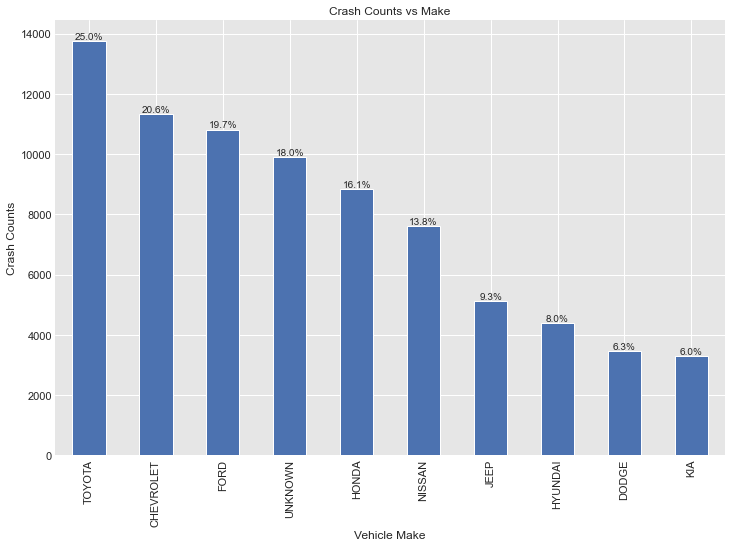

In [334]:
# Plot of Vehicle Make against their number of appearances in crashes.
vehicles.MAKE.value_counts().head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Vehicle Make')
plt.ylabel('Crash Counts')
plt.title('Crash Counts vs Make')
for i, rate in enumerate(vehicles.MAKE.value_counts().head(10)):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

In [335]:
people.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL',
       'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY',
       'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE',
       'CELL_PHONE_USE'],
      dtype='object')

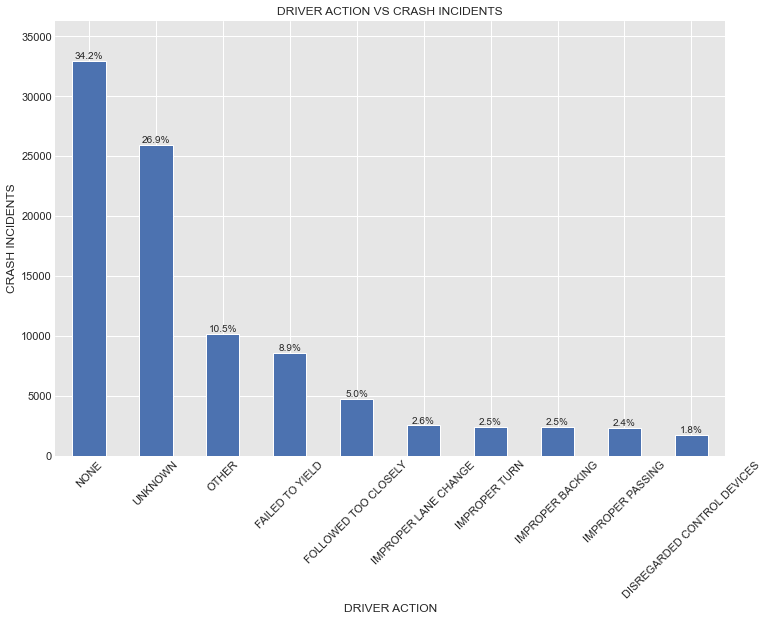

In [336]:
# Plot of Driver Action Count.
people.DRIVER_ACTION.value_counts().head(10).plot(kind='bar', figsize=(12,8))
plt.title('DRIVER ACTION VS CRASH INCIDENTS')
plt.xlabel('DRIVER ACTION')
plt.ylabel('CRASH INCIDENTS')
plt.xticks(rotation=45)
plt.ylim(0, people.DRIVER_ACTION.value_counts().max() * 1.1)
total = people.DRIVER_ACTION.value_counts().sum()
for i, rate in enumerate(people.DRIVER_ACTION.value_counts().head(10)):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

In [337]:
vehicle_agg = vehicles.groupby('CRASH_RECORD_ID').agg({
    'OCCUPANT_CNT': 'sum'
}).reset_index()

In [338]:
vehicle_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CRASH_RECORD_ID  54959 non-null  object 
 1   OCCUPANT_CNT     54959 non-null  float64
dtypes: float64(1), object(1)
memory usage: 858.9+ KB


In [339]:
people_agg = people.groupby('CRASH_RECORD_ID').agg({
    'AGE': 'mean',
    'SAFETY_EQUIPMENT': lambda x: ((x == 'SAFETY BELT USED') | 
                                   (x == 'BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)') |
                                   (x == 'CHILD RESTRAINT - REAR FACING') |
                                   (x == 'CHILD RESTRAINT - FORWARD FACING') |
                                   (x == 'BOOSTER SEAT')).sum()
}).reset_index()

In [340]:
people_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54854 entries, 0 to 54853
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CRASH_RECORD_ID   54854 non-null  object 
 1   AGE               45740 non-null  float64
 2   SAFETY_EQUIPMENT  54854 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ MB


In [341]:
people_agg.AGE.fillna(people_agg.AGE.mean(), inplace=True)

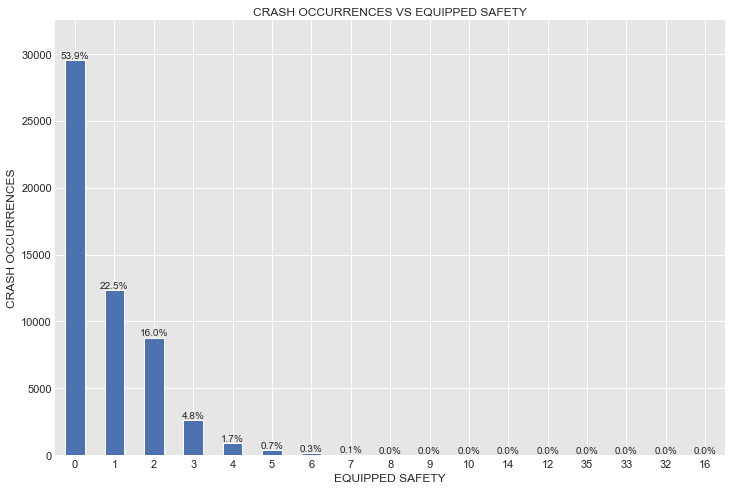

In [342]:
# Crash occurence vs safety equipment plot
equipment_rates=people_agg.SAFETY_EQUIPMENT.value_counts()
equipment_rates.plot(kind='bar', figsize=(12,8))
plt.title('CRASH OCCURRENCES VS EQUIPPED SAFETY')
plt.xlabel('EQUIPPED SAFETY')
plt.ylabel('CRASH OCCURRENCES')
plt.xticks(rotation=0)
plt.ylim(0, equipment_rates.max() * 1.1)
total = equipment_rates.sum()
for i, rate in enumerate(equipment_rates):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

In [343]:
# Merging DataFrames.
vehicle_people_df=pd.merge(people_agg, vehicle_agg, on='CRASH_RECORD_ID', how='inner')
final_df=pd.merge(crashes, vehicle_people_df, on='CRASH_RECORD_ID', how='inner')

In [344]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   CRASH_RECORD_ID          54959 non-null  object  
 1   WEATHER_CONDITION        54959 non-null  object  
 2   LIGHTING_CONDITION       54959 non-null  object  
 3   CRASH_TYPE               54959 non-null  object  
 4   CRASH_HOUR               54959 non-null  int64   
 5   CRASH_MONTH              54959 non-null  int64   
 6   NUM_UNITS                54959 non-null  int64   
 7   ROADWAY_SURFACE_COND     54959 non-null  object  
 8   POSTED_SPEED_LIMIT       54959 non-null  int64   
 9   IS_SEVERE                54959 non-null  bool    
 10  PRIM_CONTRIBUTORY_CAUSE  54959 non-null  object  
 11  SPEED_BIN                54959 non-null  category
 12  CRASH_DAY_OF_WEEK        54959 non-null  int64   
 13  TRAFFIC_CONTROL_DEVICE   54959 non-null  object  
 14  FIRST_

In [345]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54854 entries, 0 to 54853
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   CRASH_RECORD_ID          54854 non-null  object  
 1   WEATHER_CONDITION        54854 non-null  object  
 2   LIGHTING_CONDITION       54854 non-null  object  
 3   CRASH_TYPE               54854 non-null  object  
 4   CRASH_HOUR               54854 non-null  int64   
 5   CRASH_MONTH              54854 non-null  int64   
 6   NUM_UNITS                54854 non-null  int64   
 7   ROADWAY_SURFACE_COND     54854 non-null  object  
 8   POSTED_SPEED_LIMIT       54854 non-null  int64   
 9   IS_SEVERE                54854 non-null  bool    
 10  PRIM_CONTRIBUTORY_CAUSE  54854 non-null  object  
 11  SPEED_BIN                54854 non-null  category
 12  CRASH_DAY_OF_WEEK        54854 non-null  int64   
 13  TRAFFIC_CONTROL_DEVICE   54854 non-null  object  
 14  FIRST_

## MODELLING

### XGBoost Classifier Implementation

In [ ]:
# Analyzing the target variable
cause_counts = crashes['PRIM_CONTRIBUTORY_CAUSE'].value_counts()
# Identify rare causes (e.g., those appearing less than 500 times)
rare_causes = cause_counts[cause_counts < 500].index
# Grouping rare categories to reduce noise
crashes['PRIM_CONTRIBUTORY_CAUSE'] = crashes['PRIM_CONTRIBUTORY_CAUSE'].replace(rare_causes, 'OTHER')

In [ ]:
# Selecting features based on EDA
features = ['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND', 'SPEED_BIN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'FIRST_CRASH_TYPE', 'TRAFFIC_CONTROL_DEVICE', 'POSTED_SPEED_LIMIT']
X = crashes[features]
y = crashes['PRIM_CONTRIBUTORY_CAUSE']
# One-Hot Encoding categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

In [388]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [348]:
# Balancing the classes with SMOTE
#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Initializing and training the XGBoost model
#xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
#xgb_model.fit(X_resampled, y_resampled)

#### Encoding the target variable 

In [349]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [ ]:
# 2. Initialize the XGBoost Classifier
xgb_model = xgb.XGBClassifier(
n_estimators=100,
max_depth=6,
learning_rate=0.1,
random_state=42,
objective='multi:softprob', 
eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train_encoded)
y_pred_encoded = xgb_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
print(classification_report(y_test, y_pred))

c:\Users\sharo\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                                  precision    recall  f1-score   support

                                                    DISREGARDING TRAFFIC SIGNALS       0.38      0.52      0.44       225
                                             DRIVING SKILLS/KNOWLEDGE/EXPERIENCE       0.50      0.02      0.03       422
                                          FAILING TO REDUCE SPEED TO AVOID CRASH       0.40      0.00      0.01       465
                                                   FAILING TO YIELD RIGHT-OF-WAY       0.39      0.24      0.30      1291
                                                           FOLLOWING TOO CLOSELY       0.42      0.59      0.49       979
                                                                IMPROPER BACKING       0.43      0.23      0.30       342
                                                             IMPROPER LANE USAGE       0.36      0.02      0.04       371
                       

#### **The model shows a huge class imbalance**

#### Reducing the number of classes in the 'PRIMARY_CONTRIBUTORY_CAUSE' column by grouping similar causes together.

In [382]:
grouping_map = {
'UNABLE TO DETERMINE': 'UNKNOWN',
'NOT APPLICABLE': 'UNKNOWN',
'FAILING TO YIELD RIGHT-OF-WAY': 'VIOLATION',
'DISREGARDING TRAFFIC SIGNALS': 'VIOLATION',
'FOLLOWING TOO CLOSELY': 'DRIVER_ERROR',
'IMPROPER BACKING': 'DRIVER_ERROR',
'IMPROPER LANE USAGE': 'DRIVER_ERROR',
'IMPROPER TURNING/NO SIGNAL': 'DRIVER_ERROR',
'IMPROPER OVERTAKING/PASSING': 'DRIVER_ERROR',
'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': 'DRIVER_ERROR',
'WEATHER': 'ENVIRONMENT',
'FAILING TO REDUCE SPEED TO AVOID CRASH': 'SPEED_RELATED'
}
y_grouped = y.map(grouping_map).fillna('OTHER')

#### Re-encoding	the primary cause column with the new grouped causes.

In [353]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_grouped)

#### Calculating the class weights to address class imbalance in the target variable.

In [ ]:
classes = np.unique(y_encoded)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_encoded)
weights_dict = dict(zip(classes, weights))


#### Adjusting the weight for class ENVIRONMENT to prevent overfitting to that class

In [ ]:
env_idx = list(label_encoder.classes_).index('ENVIRONMENT') #(Finding which index is ENVIRONMENT)
weights_dict[env_idx] = weights_dict[env_idx] * 0.7  # Reducing weight by 30% to reduce sensitivity to that class

#### splitting the data	into training and testing sets

In [369]:
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [363]:
# Map weights to each individual sample in the training set
sample_weights = np.array([weights_dict[label] for label in y_train_encoded])

#### Training the XGBoost model with the resampled data

In [364]:
xgb_model = xgb.XGBClassifier(
n_estimators=100,
max_depth=6,
learning_rate=0.1,
random_state=42,
objective='multi:softprob', 
eval_metric='mlogloss'
)


#### Fitting the	XGBoost model with sample weights to address class imbalance.

In [365]:
xgb_model.fit(X_train, y_train_encoded, sample_weight=sample_weights)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Evaluation

In [366]:
y_pred_encoded = xgb_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

In [367]:
print(classification_report(y_test_labels, y_pred))

               precision    recall  f1-score   support

 DRIVER_ERROR       0.42      0.27      0.33      3130
  ENVIRONMENT       0.15      0.84      0.25       139
        OTHER       0.17      0.26      0.21       723
SPEED_RELATED       0.10      0.37      0.16       454
      UNKNOWN       0.68      0.33      0.44      5032
    VIOLATION       0.35      0.71      0.47      1514

     accuracy                           0.37     10992
    macro avg       0.31      0.46      0.31     10992
 weighted avg       0.50      0.37      0.38     10992



#### **The low precision for ENVIRONMENT and SPEED_RELATED suggests the model is still a bit "overfiting" to those conditions. The model performs reasonably well on other classes.**

## Random Forest Classifier Implementation

In [ ]:
# 1. Map the 14 causes into the 6 broad categories
grouping_map = {
'UNABLE TO DETERMINE': 'UNKNOWN',
'NOT APPLICABLE': 'UNKNOWN',
'FAILING TO YIELD RIGHT-OF-WAY': 'VIOLATION',
'DISREGARDING TRAFFIC SIGNALS': 'VIOLATION',
'FOLLOWING TOO CLOSELY': 'DRIVER_ERROR',
'IMPROPER BACKING': 'DRIVER_ERROR',
'IMPROPER LANE USAGE': 'DRIVER_ERROR',
'IMPROPER TURNING/NO SIGNAL': 'DRIVER_ERROR',
'IMPROPER OVERTAKING/PASSING': 'DRIVER_ERROR',
'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': 'DRIVER_ERROR',
'WEATHER': 'ENVIRONMENT',
'FAILING TO REDUCE SPEED TO AVOID CRASH': 'SPEED_RELATED'
}


In [ ]:
# Grouping (everything else becomes 'OTHER')
y_final = crashes['PRIM_CONTRIBUTORY_CAUSE'].map(grouping_map).fillna('OTHER')

In [ ]:
# Re-fit the LabelEncoder on these 6 categories
le_rf = LabelEncoder()
y_encoded = le_rf.fit_transform(y_final)

In [ ]:
# Spliting the data again to ensure X and y are perfectly aligned
X_train, X_test, y_train, y_test = train_test_split(
X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [386]:
# 4. Initialize and Train the Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1, max_depth=12)
rf_model.fit(X_train, y_train)
# 5. Check the accuracy
accuracy = rf_model.score(X_test, y_test)
# Test set predictions
y_pred_rf = rf_model.predict(X_test)


In [387]:
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

 DRIVER_ERROR       0.43      0.23      0.30      3130
  ENVIRONMENT       0.14      0.85      0.24       139
        OTHER       0.16      0.25      0.20       723
SPEED_RELATED       0.10      0.36      0.16       454
      UNKNOWN       0.68      0.34      0.46      5032
    VIOLATION       0.33      0.68      0.44      1514

     accuracy                           0.36     10992
    macro avg       0.31      0.45      0.30     10992
 weighted avg       0.49      0.36      0.38     10992



#### ENVIRONMENT has very high recall (0.85) but extremely low precision (0.14). Meaning the model predicts ENVIRONMENT very often. 

In [ ]:
# Target and feature selection
target = final_df.IS_SEVERE
features = final_df.drop(columns=['CRASH_RECORD_ID', 'IS_SEVERE'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

In [ ]:
# Data types selection.
X_train_cat=X_train.select_dtypes(exclude=['int64','float64']).copy()
X_train_num=X_train.select_dtypes(include=['int64','float64']).copy()

In [ ]:
# Scaling and encoding the train data.
scaler=StandardScaler()
X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train_num), index=X_train_num.index, columns=X_train_num.columns)
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_ohe_array = ohe.fit_transform(X_train_cat)
column_names = []
for i, cats in enumerate(ohe.categories_):
    column_names.extend([f"{X_train_cat.columns[i]}_{cat}" for cat in cats[:]])

X_train_ohe = pd.DataFrame(X_train_ohe_array, index=X_train_cat.index, columns=column_names)
X_train_ohe.head()

,WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,WEATHER_CONDITION_FOG/SMOKE/HAZE,WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,WEATHER_CONDITION_OTHER_RARE,WEATHER_CONDITION_RAIN,WEATHER_CONDITION_SEVERE CROSS WIND GATE,WEATHER_CONDITION_SLEET/HAIL,WEATHER_CONDITION_SNOW,...,PRIM_CONTRIBUTORY_CAUSE_TURNING RIGHT ON RED,PRIM_CONTRIBUTORY_CAUSE_UNABLE TO DETERMINE,PRIM_CONTRIBUTORY_CAUSE_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"PRIM_CONTRIBUTORY_CAUSE_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",PRIM_CONTRIBUTORY_CAUSE_WEATHER,SPEED_BIN_30-35,SPEED_BIN_40-45,SPEED_BIN_50-55,SPEED_BIN_60-65,SPEED_BIN_≤25
36739,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12156,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
44397,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
46994,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Merging columns.
X_train_full=pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_train_full.head()

,CRASH_HOUR,CRASH_MONTH,NUM_UNITS,POSTED_SPEED_LIMIT,CRASH_DAY_OF_WEEK,AGE,SAFETY_EQUIPMENT,OCCUPANT_CNT,WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,...,PRIM_CONTRIBUTORY_CAUSE_TURNING RIGHT ON RED,PRIM_CONTRIBUTORY_CAUSE_UNABLE TO DETERMINE,PRIM_CONTRIBUTORY_CAUSE_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"PRIM_CONTRIBUTORY_CAUSE_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",PRIM_CONTRIBUTORY_CAUSE_WEATHER,SPEED_BIN_30-35,SPEED_BIN_40-45,SPEED_BIN_50-55,SPEED_BIN_60-65,SPEED_BIN_≤25
36739,0.155998,-0.811417,-0.081371,0.284961,-0.544493,-1.427904,1.039315,-0.096201,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12156,-0.561330,0.948609,4.696001,0.284961,-1.554538,1.211448,1.039315,1.498025,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16558,0.873326,0.948609,-0.081371,0.284961,1.475596,-0.797611,-0.722292,-0.096201,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
44397,1.411322,-0.811417,-0.081371,0.284961,1.475596,-1.309724,0.158511,-0.893313,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
46994,-2.354650,-1.398092,-0.081371,-5.093441,1.475596,-1.309724,-0.722292,-0.893313,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Data types selection.
X_test_cat=X_test.select_dtypes(exclude=['int64','float64']).copy()
X_test_num=X_test.select_dtypes(include=['int64','float64']).copy()

In [ ]:
# Scaling and encoding the test data.
scaler=StandardScaler()
X_test_scaled=pd.DataFrame(scaler.fit_transform(X_test_num), index=X_test_num.index, columns=X_test_num.columns)
X_test_ohe_array = ohe.fit_transform(X_test_cat)
# Get column names correctly without dropping first category
column_names = []
for i, cats in enumerate(ohe.categories_):
    column_names.extend([f"{X_test_cat.columns[i]}_{cat}" for cat in cats[:]])
X_test_ohe = pd.DataFrame(X_test_ohe_array, index=X_test_cat.index, columns=column_names)
X_test_ohe.head()

,WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,WEATHER_CONDITION_FOG/SMOKE/HAZE,WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,WEATHER_CONDITION_OTHER_RARE,WEATHER_CONDITION_RAIN,WEATHER_CONDITION_SEVERE CROSS WIND GATE,WEATHER_CONDITION_SLEET/HAIL,WEATHER_CONDITION_SNOW,...,PRIM_CONTRIBUTORY_CAUSE_TURNING RIGHT ON RED,PRIM_CONTRIBUTORY_CAUSE_UNABLE TO DETERMINE,PRIM_CONTRIBUTORY_CAUSE_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"PRIM_CONTRIBUTORY_CAUSE_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",PRIM_CONTRIBUTORY_CAUSE_WEATHER,SPEED_BIN_30-35,SPEED_BIN_40-45,SPEED_BIN_50-55,SPEED_BIN_60-65,SPEED_BIN_≤25
3290,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
46998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21597,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41169,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11545,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Merging columns.
X_test_full=pd.concat([X_test_scaled, X_test_ohe], axis=1)
X_test_full.head()

,CRASH_HOUR,CRASH_MONTH,NUM_UNITS,POSTED_SPEED_LIMIT,CRASH_DAY_OF_WEEK,AGE,SAFETY_EQUIPMENT,OCCUPANT_CNT,WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,...,PRIM_CONTRIBUTORY_CAUSE_TURNING RIGHT ON RED,PRIM_CONTRIBUTORY_CAUSE_UNABLE TO DETERMINE,PRIM_CONTRIBUTORY_CAUSE_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"PRIM_CONTRIBUTORY_CAUSE_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",PRIM_CONTRIBUTORY_CAUSE_WEATHER,SPEED_BIN_30-35,SPEED_BIN_40-45,SPEED_BIN_50-55,SPEED_BIN_60-65,SPEED_BIN_≤25
3290,-0.018096,1.534072,-0.078183,0.283610,-0.047926,0.222252,-0.691602,-0.121126,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
46998,1.773776,-1.408858,-0.078183,0.283610,0.967165,-0.284659,0.142222,-0.121126,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21597,1.415402,0.356900,-0.078183,-2.428821,-0.047926,-0.001443,-0.691602,-0.947221,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41169,-1.451594,-0.820272,2.231794,-0.620534,-0.047926,-0.284659,-0.691602,-0.947221,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11545,0.340278,0.945486,-0.078183,0.283610,-0.555472,-1.779394,-0.691602,8.139823,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### RANDOM FOREST CLASSIFIER

In [ ]:
# Instantiating a Random Forest Classifier
rf_clf=RandomForestClassifier(class_weight='balanced', random_state=42)
rf_clf.fit(X_train_full, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

KeyboardInterrupt: 

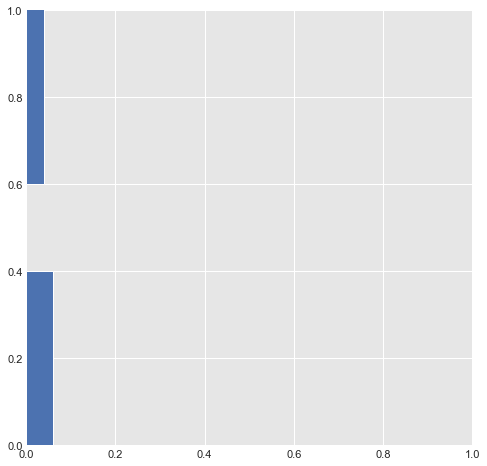

In [ ]:
def plot_feature_importances(model):
    n_features = X_train_full.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_full.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(rf_clf)

In [ ]:
# Test set predictions
pred = rf_clf.predict(X_test_full)
# Classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99     16200
        True       0.13      0.01      0.01       257

    accuracy                           0.98     16457
   macro avg       0.56      0.50      0.50     16457
weighted avg       0.97      0.98      0.98     16457



In [ ]:
print(rf_clf.score(X_train_full, y_train))
print(rf_clf.score(X_test_full, y_test))

0.9997656066880225
0.9837151364161147


In [ ]:
rf_param_grid = {'n_estimators': [10, 30],
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 2, 5, 10],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 3, 5]}
rf_grid_search = GridSearchCV(rf_clf, param_grid=rf_param_grid, cv=3, return_train_score=True)
rf_grid_search.fit(X_train_full, y_train)
print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 98.38%
Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}


In [ ]:
rf_clf_2=RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=30, class_weight='balanced', random_state=42)
rf_clf_2.fit(X_train_full, y_train)
pred=rf_clf_2.predict(X_test_full)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99     16200
        True       0.13      0.01      0.01       257

    accuracy                           0.98     16457
   macro avg       0.56      0.50      0.50     16457
weighted avg       0.97      0.98      0.98     16457



## The recall is so low due to severe class imbalance.

## Now for Synthetic Minority Oversampling technique (SMOTE)

In [ ]:
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_full, y_train)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=30,
    class_weight='balanced',   
    max_depth=None,             
    min_samples_leaf=1,       
    min_samples_split=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced', max_features='sqrt',
                       n_estimators=30, n_jobs=-1, random_state=42)

In [ ]:
y_pred_rf = rf.predict(X_test_full)

In [ ]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

       False       0.99      0.83      0.90     16200
        True       0.06      0.64      0.10       257

    accuracy                           0.83     16457
   macro avg       0.52      0.73      0.50     16457
weighted avg       0.98      0.83      0.89     16457



## XGBoost

In [ ]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train_full, y_train)

# Predict on training and test sets
training_preds = clf.predict(X_train_full)
test_preds = clf.predict(X_test_full)

print('Training Accuracy: {:.4}%'.format(accuracy_score(y_train, training_preds) * 100))
print('Validation accuracy: {:.4}%'.format(accuracy_score(y_test, test_preds) * 100))
print('Training Recall: {:.4}%'.format(recall_score(y_train, training_preds)))
print('Validation Recall: {:.4}%'.format(recall_score(y_test, test_preds)))

Training Accuracy: 98.66%
Validation accuracy: 98.38%
Training Recall: 0.1436%
Validation Recall: 0.0%


The model has high accuracy but fails to identify severe crashes. This is because severe crashes are rare, which makes accuracy misleading. Recall is more important for this task, since correctly identifying severe crashes is critical for safety.

## Very low recall

In [ ]:
scale_pos_weight = (
    y_train.value_counts()[0] / y_train.value_counts()[1]
)
model = XGBClassifier(
    n_estimators=400,            
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,                
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    random_state=42
)
model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='aucpr',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=63.101836393989984, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [5, 10, 20],
    'gamma': [0, 1, 5]
}
grid = GridSearchCV(
    model,
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)
grid.fit(X_train_res, y_train_res)
best_model = grid.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test_full)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

       False      1.000     0.725     0.840     16200
        True      0.054     0.996     0.103       257

    accuracy                          0.729     16457
   macro avg      0.527     0.860     0.472     16457
weighted avg      0.985     0.729     0.829     16457



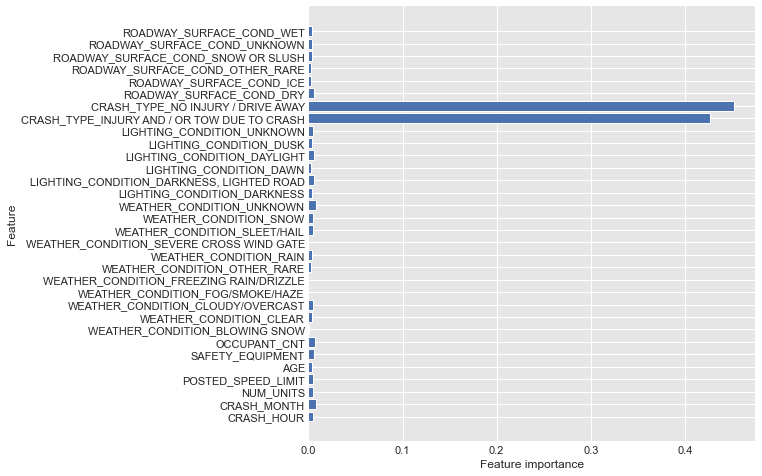

In [ ]:
plot_feature_importances(best_model)

## The most important feature in our xgboost model is crash type injury and or tow due to crash.This means whether a crash causes injury or needs a tow is the biggest factor in predicting crash outcomes.